In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
from scipy.integrate import solve_ivp
from scipy.spatial.transform import Rotation

0.766044443118978 0.0 0.6427876096865393 0.0
0.0
1.6055304451500688e-06
1.6055304451500688e-06
3.2110608903001375e-06
3.2110608903001375e-06
0.016058515512390986
0.016058515512390986
0.03211381996389168
0.03211381996389168
0.04816912441539237
0.04816912441539237
0.13291726038839263
0.13291726038839263
0.21766539636139293
0.21766539636139293
0.3024135323343932
0.3024135323343932
0.23885243035464299
0.23885243035464299
0.26003946434789305
0.26003946434789305
0.239331014312828
0.239331014312828
0.239809598271013
0.239809598271013
0.240288182229198
0.240288182229198
0.24076676618738302
0.24076676618738302
0.24099183604500468
0.24099183604500468
0.24121690590262634
0.24121690590262634
0.241441975760248
0.241441975760248
0.2416668529079472
0.2416668529079472
0.2418917300556464
0.2418917300556464
0.2421166072033456
0.2421166072033456
0.24234129205201163
0.24234129205201163
0.24256597690067766
0.24256597690067766
0.2427906617493437
0.2427906617493437
0.24503751023600398
0.24503751023600398
0.2

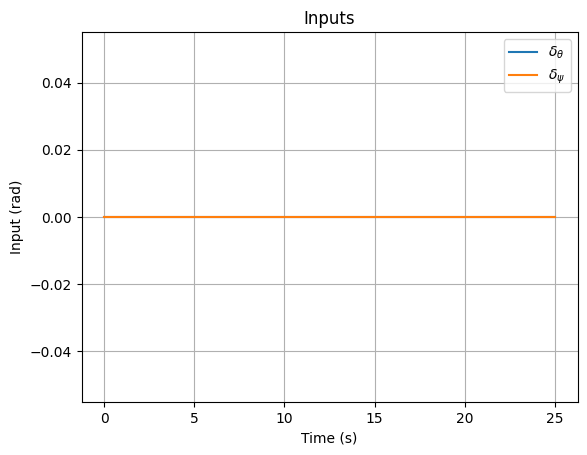

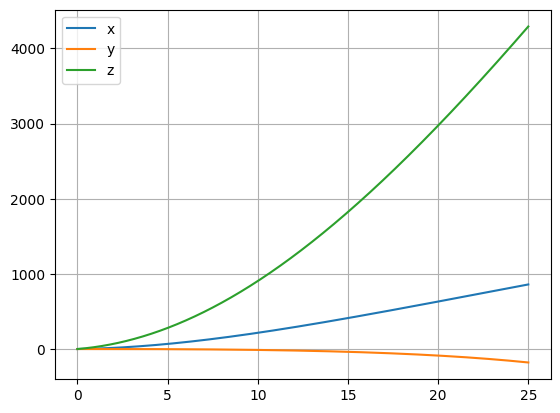

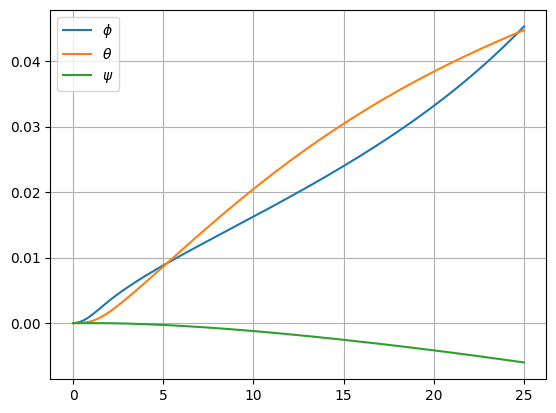

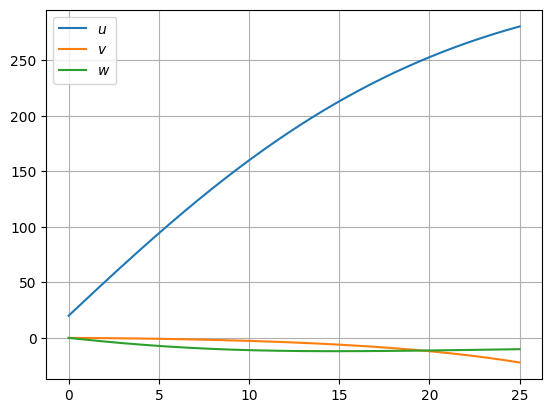

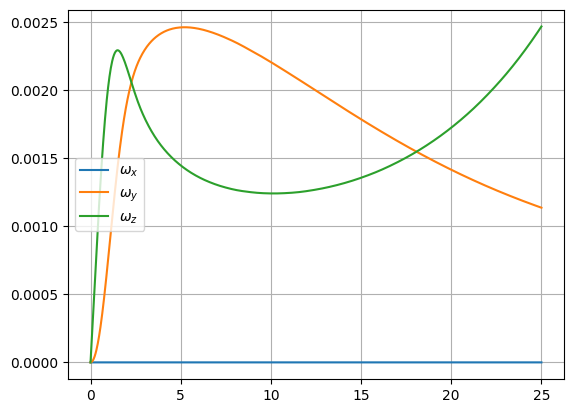

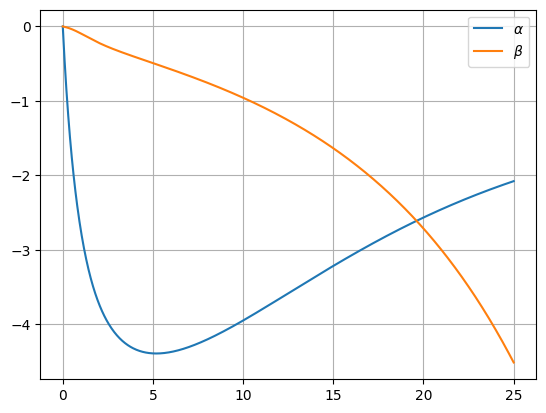

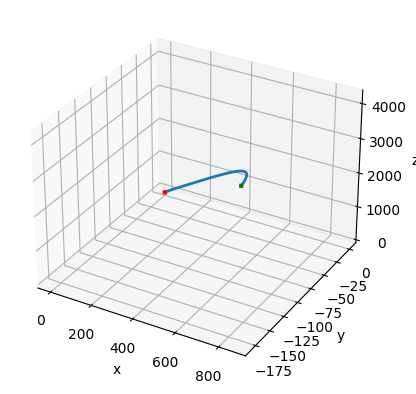

In [2]:
# Definição do empuxo
T = 500 # N

# Constantes
g = 9.81 # m/s^2
rho = 1.091 # kg/m^3
d = 0.127 # m
S = np.pi * (d/2)**2 # m^2
C_D = 0.15
m = 20 # kg
J = np.array([[0.007, 0, 0], [0, 22, 0], [0, 0, 22]]) # matriz de inércia (kg*m^2)
x_gimbal = 1.4 # m
x_cp = 2*0.127 # m
L = 3 # m (comprimento de referência)

# coeficientes aerodinâmicos

# coeficientes de força
C_a_0 = 0.4
C_a_alpha = 0.05
C_a_beta = 0.05
C_s_0 = 0
C_s_beta = 0.9
C_n_0 = 0
C_n_alpha = 1.2
# coeficientes de momento
C_roll_p = 1.6
C_pitch_alpha = 0.05
C_pitch_q =1.6
C_yaw_beta = 0.05
C_yaw_r = 1.6

# sinais de entrada
# d_theta = lambda t: -0.005 if 2 < t < 5 else 0
# d_psi = lambda t: 0.000 if 3 < t < 5 else 0

# sinal nulo
d_theta = lambda t: 0
d_psi = lambda t: 0

# disturbios
wind_x = lambda t: -0.02*t**2 + 0.5*t + 0.5
wind_y = lambda t: -0.013*t**2 + 0.22*t + 2.64

# disturbio nulo
# wind_x = lambda t: 0
# wind_y = lambda t: 0

# função que retorna as forças e momentos decorrentes do empuxo
def thrust(q0,q1,q2,q3,delta_theta, delta_psi):
    # thrust vector in body frame
    thrust_vector = np.array([T*np.cos(delta_theta)*np.cos(delta_psi), T*np.sin(delta_psi),T*np.sin(delta_theta)])
    moment_thrust = np.cross(np.array([-x_gimbal, 0, 0]), thrust_vector)
    
    return thrust_vector, moment_thrust

# função que retorna as forças e momentos decorrentes da aerodinâmica
def aero(u,v,w,q0,q1,q2,q3,p,q,r,wind):
    # velocidade relativa ao vento
    u_rel = u - wind[0]
    v_rel = v - wind[1]
    w_rel = w - wind[2]

    alpha = np.arctan2(w_rel,u_rel)
    beta = np.arctan2(v_rel,u_rel)


    # calcula as forças aerodinâmicas
    C_a = C_a_0 + C_a_alpha*alpha + C_a_beta*beta
    C_s = C_s_0 + C_s_beta*beta
    C_n = C_n_0 + C_n_alpha*alpha
    axial = 0.5*C_a*rho*S*(u_rel**2+v_rel**2+w_rel**2)
    side = 0.5*C_s*rho*S*(u_rel**2+v_rel**2+w_rel**2)
    normal = 0.5*C_n*rho*S*(u_rel**2+v_rel**2+w_rel**2)
    aero_forces = np.array([-axial, side, -normal])

    # calcula os momentos aerodinâmicos
    C_roll = C_roll_p*p
    C_pitch = C_pitch_alpha*alpha + C_pitch_q*q
    C_yaw = C_yaw_beta*beta + C_yaw_r*r
    roll = 0.5*C_roll*rho*S*(u_rel**2+v_rel**2+w_rel**2)*L
    pitch = 0.5*C_pitch*rho*S*(u_rel**2+v_rel**2+w_rel**2)*L
    yaw = 0.5*C_yaw*rho*S*(u_rel**2+v_rel**2+w_rel**2)*L
    aero_moments = np.array([-roll, -pitch, -yaw])
    #aero_moments = np.cross(np.array([-x_cp, 0, 0]), aero_forces)

    return aero_forces, aero_moments
    
def fun(t,y):
    print(t)
    # matriz de rotação
    rot = Rotation.from_quat([y[7], y[8], y[9], y[6]])
    rotation_matrix = rot.as_matrix()
    inv_rotation_matrix = np.linalg.inv(rotation_matrix)

    # entradas
    u_0 = d_theta(t)
    u_1 = d_psi(t)

    # disturbios
    d_w = np.array([wind_x(t), wind_y(t), 0])

    # forças e momentos decorrentes do empuxo
    thrust_force,moment_thrust  = thrust(y[6],y[7],y[8],y[9], u_0, u_1)

    # forças e momentos decorrentes da aerodinâmica
    aero_force,aero_moments = aero(y[3],y[4],y[5],y[6],y[7],y[8],y[9],y[10],y[11],y[12],d_w)

    # gravidade
    gravity_inertial = np.array([0,0,-m*g])
    gravity_body = np.dot(rotation_matrix, gravity_inertial) # converte para o sistema de referência do corpo

    # derivadas de velocidade e posição
    u_dot = (1/m)*(thrust_force + aero_force+ gravity_body) - np.cross(np.array([y[10],y[11],y[12]]), np.array([y[3],y[4],y[5]]))
    r_dot = np.dot(inv_rotation_matrix, np.array([y[3], y[4], y[5]])) # converte para o sistema de referência inercial

    # matriz de derivadas dos quaternions
    transformation_matrix = np.array([[0, -y[10], -y[11], -y[12]], [y[10], 0, y[12], -y[11]], [y[11], -y[12], 0, y[10]], [y[12], y[11], -y[10], 0]])
    # derivadas dos quaternions em função da velocidade angular
    quaternion_dot = 0.5*np.dot(transformation_matrix, np.array([y[6], y[7], y[8], y[9]]))

    # aceleração angular
    J_inv = np.linalg.inv(J)
    omega_dot = np.dot(J_inv, moment_thrust+aero_moments - np.cross(y[10:13], np.dot(J, y[10:13])))

    return np.array([r_dot[0], r_dot[1], r_dot[2], u_dot[0], u_dot[1], u_dot[2], quaternion_dot[0], quaternion_dot[1], quaternion_dot[2], quaternion_dot[3], omega_dot[0], omega_dot[1], omega_dot[2]])



# Condicoes iniciais
# Angulo de inclinação do trilho (em graus)
elevation = 80

x0 = 0
y0 = 0
z0 = 0
u0 = 20
v0 = 0
w0 = 0
phi0 = (0/90)*np.pi/2
theta0 = (elevation/90)*np.pi/2
psi0 = (0/90)*np.pi/2
p0 = 0
q0 = 0
r0 = 0

rot_0 = Rotation.from_euler('zyx', [phi0, theta0, psi0], degrees=False)

# print initial quaternions
q1_0, q2_0, q3_0, q0_0 = rot_0.as_quat()
print(q0_0, q1_0, q2_0, q3_0)

# vetor com as condições iniciais
y_0 = np.array([x0, y0, z0, u0, v0, w0, q0_0, q1_0, q2_0, q3_0,p0, q0, r0])
t_span = (0, 25)

# resolução do sistema de equações diferenciais pelo método de Adams (LSODA)
sol = solve_ivp(fun, t_span, y_0, method='LSODA', t_eval=np.linspace(0, 25, 1000), vectorized=False)

# plotagem dos resultados
d_theta_list = []
d_psi_list = []
# calcula as entradas para cada instante de tempo
for t in sol.t:
    d_theta_list.append(d_theta(t))
    d_psi_list.append(d_psi(t))

# plot das entradas
plt.figure(0)
plt.plot(sol.t, d_theta_list)
plt.plot(sol.t, d_psi_list)
plt.legend([r'$\delta_{\theta}$', r'$\delta_{\psi}$'])
plt.xlabel('Time (s)')
plt.ylabel('Input (rad)')
plt.title('Inputs')
plt.grid()

# plot da posição
plt.figure(1)
plt.plot(sol.t, sol.y[0, :])
plt.plot(sol.t, sol.y[1, :])
plt.plot(sol.t, sol.y[2, :])
plt.legend(['x', 'y', 'z'])
plt.grid()

#plot dos ângulos de Euler
plt.figure(2)
phi_array = []
theta_array = []
psi_array = []
# conversão dos quaternions para ângulos de Euler
for i in range(len(sol.t)):
    rot = Rotation.from_quat([sol.y[7, i], sol.y[8, i], sol.y[9, i], sol.y[6, i]])
    phi_array.append(rot.as_euler('zyx')[0])
    theta_array.append(rot.as_euler('zyx')[1])
    psi_array.append(rot.as_euler('zyx')[2])
plt.plot(sol.t, phi_array)
plt.plot(sol.t, np.array(theta_array)-theta0)
plt.plot(sol.t, psi_array)
plt.legend([r'$\phi$', r'$\theta$', r'$\psi$'])
plt.grid()

#plot das velocidades
plt.figure(4)
plt.plot(sol.t, sol.y[3, :])
plt.plot(sol.t, sol.y[4, :])
plt.plot(sol.t, sol.y[5, :])
plt.legend([r'$u$', r'$v$', r'$w$'])
plt.grid()

#plot das velocidades angulares
plt.figure(3)
plt.plot(sol.t, sol.y[10, :])
plt.plot(sol.t, sol.y[11, :])
plt.plot(sol.t, sol.y[12, :])
plt.legend([r'$\omega_x$', r'$\omega_y$', r'$\omega_z$'])
plt.grid()
plt.show()

# plot dos ângulos de ataque e de sideslip
plt.figure(7)
alpha = np.arctan2(sol.y[5, :], sol.y[3, :])
beta = np.arctan2(sol.y[4, :], sol.y[3, :])
plt.plot(sol.t, alpha*180/np.pi)
plt.plot(sol.t, beta*180/np.pi)
plt.legend([r'$\alpha$', r'$\beta$'])
plt.grid()
plt.show()

# plot da trajetória 3D
fig = plt.figure(4)
ax = fig.add_subplot(111, projection='3d')
ax.plot(sol.y[0, :], sol.y[1, :], sol.y[2, :], linewidth=2)
ax.plot([0, 0], [0, 0], [0, 1], 'r', linewidth=3)
ax.plot([sol.y[0, -1], sol.y[0, -1]], [sol.y[1, -1], sol.y[1, -1]], [sol.y[2, -1], sol.y[2, -1] + 1], 'g', linewidth=3)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
plt.show()


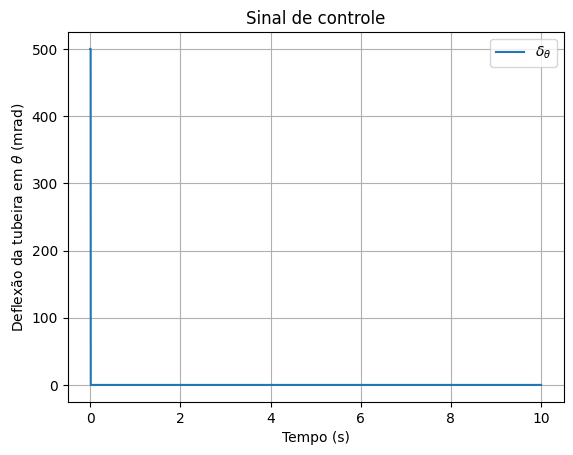

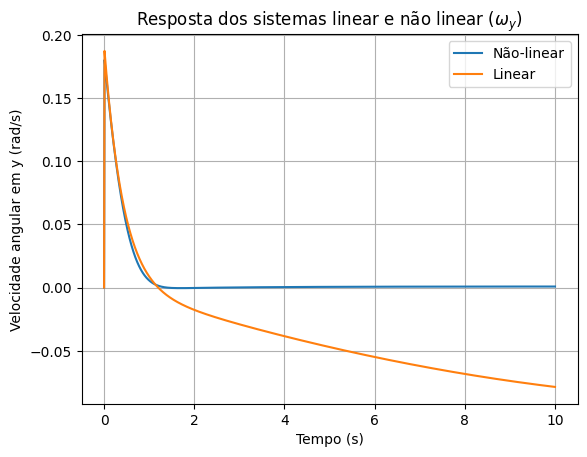

In [16]:
import control as ct

T = 600

def model(t,y,u,params):
    # matriz de rotação
    rot = Rotation.from_euler('zyx', [y[6], y[7], y[8]], degrees=False)
    rotation_matrix = rot.as_matrix()
    inv_rotation_matrix = np.linalg.inv(rotation_matrix)

    # entradas
    u_0 = u[0]
    u_1 = 0

    # disturbios
    wind_x = u[1]
    wind_y = u[2]
    wind_z = 0
    wind = np.array([wind_x, wind_y, wind_z])

    # forças e momentos devido a propulsão
    thrust_force  = thrust(0,0,0,0, u_0, u_1)[0]
    moment_thrust = thrust(0,0,0,0, u_0, u_1)[1]

    # forças e momentos devido a aerodinâmica
    aero_force,aero_moments = aero(y[3],y[4],y[5],0,0,0,0,y[9],y[10],y[11],wind)

    # gravidade
    gravity_inertial = np.array([0,0,-m*g])
    gravity_body = np.dot(rotation_matrix, gravity_inertial)

    u_dot = (1/m)*(thrust_force + aero_force+ gravity_body) - np.cross(np.array([y[9],y[10],y[11]]), np.array([y[3],y[4],y[5]]))
    #u_dot = np.array([0,0,0]) #equilíbrio de forças pro modelo linearizado
    r_dot = np.dot(inv_rotation_matrix, np.array([y[3], y[4], y[5]]))

    # derivadas dos angulos de euler
    transformation_matrix = np.array([[1, np.sin(y[6])*np.tan(y[7]), np.cos(y[6])*np.tan(y[7])], [0, np.cos(y[6]), -np.sin(y[6])], [0, np.sin(y[6])/np.cos(y[7]), np.cos(y[6])/np.cos(y[7])]])
    phi_dot, theta_dot, psi_dot = np.dot(transformation_matrix, np.array([y[9], y[10], y[11]]))

    # aceleração angular
    J_inv = np.linalg.inv(J)
    omega_dot = np.dot(J_inv, moment_thrust+aero_moments - np.cross(y[9:12], np.dot(J, y[9:12])))

    return np.array([r_dot[0], r_dot[1], r_dot[2], u_dot[0], u_dot[1], u_dot[2], phi_dot, theta_dot, psi_dot, omega_dot[0], omega_dot[1], omega_dot[2]])

# define função de saída: y
def output(t,y,u,params):
    return y[10]

# Definição do modelo não-linear como um objeto do tipo IOSystem
rocket_model = ct.NonlinearIOSystem(model,outfcn=output,inputs=['dtheta','wind_x','wind_y'], output='theta')

# Linearização do modelo não-linear
ss = ct.linearize(sys=rocket_model, xeq=[0,0,0,40,0,0,0, (80/90)*np.pi/2, 0,0,0,0], ueq=[0,0,0])

# vetor de tempos
time_vector = np.linspace(0, 10, 100000)   # Simulation 

U = np.zeros((3,100000))

# Definição do sinal de entrada
d_theta_array = []
for elem in time_vector:
    if elem < 0.01:
        d_theta_array.append(0.5)
    else:
        d_theta_array.append(0)
U[0,:] = d_theta_array

#Definição dos disturbios
dwind = np.zeros((2,100000))
for elem in time_vector:
    dwind[0] = wind_x(elem)
    dwind[1] = wind_y(elem)
U[1,:] = dwind[0,:] #disturbio em x
U[2,:] = dwind[1,:] #disturbio em y

# plota U
plt.figure(4)
plt.plot(time_vector, U[0,:]*1000)
plt.title('Sinal de controle')
plt.xlabel('Tempo (s)')
plt.ylabel('Deflexão da tubeira em ' + r'$\theta$' + ' (mrad)')
plt.legend([r'$\delta_\theta$'])
plt.grid()

# Simula o sistema não-linear e linear
X0 = [0,0,0,40,0,0,0, (80/90)*np.pi/2, 0,0,0,0]
t, y = ct.input_output_response(rocket_model, time_vector, U, X0, solve_ivp_method='LSODA')
t_linear, y_linear = ct.input_output_response(ss, time_vector, U, X0, solve_ivp_method='LSODA')

# Plot de theta (DESCOMENTAR E TROCAR A SAÍDA PARA USAR)

# plt.figure(5)
# plt.title('Resposta dos sistemas linear e não linear '+r'$(\theta)$')
# plt.plot(t, y*180/np.pi, label='Não-linear')
# plt.xlabel('Tempo (s)')	
# plt.ylabel('Ângulo de arfagem (graus)')
# plt.plot(t_linear, y_linear*180/np.pi, label='Linear')
# plt.legend()
# plt.grid()
# plt.show()

# Plot de omega
plt.figure(5)
plt.title('Resposta dos sistemas linear e não linear '+r'$(\omega_y)$')
plt.plot(t, y[0,:], label='Não-linear')  # extract first row of y
plt.xlabel('Tempo (s)')	
plt.ylabel('Velocidade angular em y (rad/s)')
plt.plot(t_linear, y_linear[0,:], label='Linear')
plt.legend()
plt.grid()
plt.show()


[[-1.10563576e-02 -6.91024127e-04 -1.70348379e+00  0.00000000e+00]
 [ 0.00000000e+00 -1.65845357e-02  9.66096491e+00  4.00000000e+01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]
 [ 0.00000000e+00 -1.88460634e-03  0.00000000e+00 -2.41229612e+00]]

[[-1.50031099e-05]
 [ 3.00000000e+01]
 [ 0.00000000e+00]
 [ 3.81818182e+01]]
[-0.01105636+0.j         -2.38367618+0.j         -0.02260223+0.08442387j
 -0.02260223-0.08442387j]


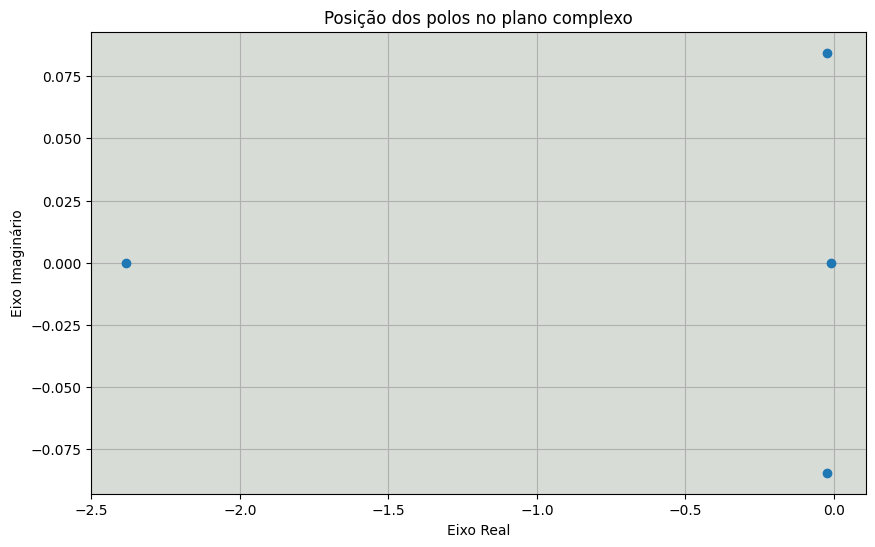

In [17]:
A_full = ss.A
B_full = ss.B


A = np.array([[A_full[3][3],A_full[3][5],A_full[3][7],A_full[3][10]],
              [A_full[5][3],A_full[5][5],A_full[5][7],A_full[5][10]],
              [A_full[7][3],A_full[7][5],A_full[7][7],A_full[7][10]],
              [A_full[10][3],A_full[10][5],A_full[10][7],A_full[10][10]]])

B = np.array([[B_full[3][0]],[B_full[5][0]],[B_full[7][0]],[B_full[10][0]]])

print(A) # print a matriz A do estado reduzido
print()
print(B) # print a matriz B do estado reduzido

# print os autovalores de A
print(np.linalg.eig(A)[0])

# plot dos autovalores no plano complexo
plt.figure(1, figsize=(10, 6))
plt.plot(np.real(np.linalg.eig(A)[0]), np.imag(np.linalg.eig(A)[0]), 'o')
plt.title('Posição dos polos no plano complexo')
plt.xscale('linear')
plt.xlabel('Eixo Real')
plt.ylabel('Eixo Imaginário')
plt.gca().set_facecolor('xkcd:light grey')
plt.grid()
plt.show()



C:\Users\sscai\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\scipy\signal\_filter_design.py:1746: BadCoefficients: Badly conditioned filter coefficients (numerator): the results may be meaningless
  warnings.warn("Badly conditioned filter coefficients (numerator): the "


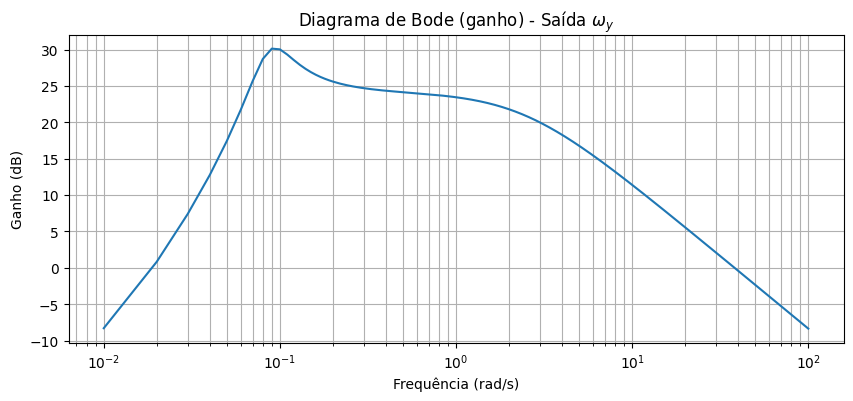

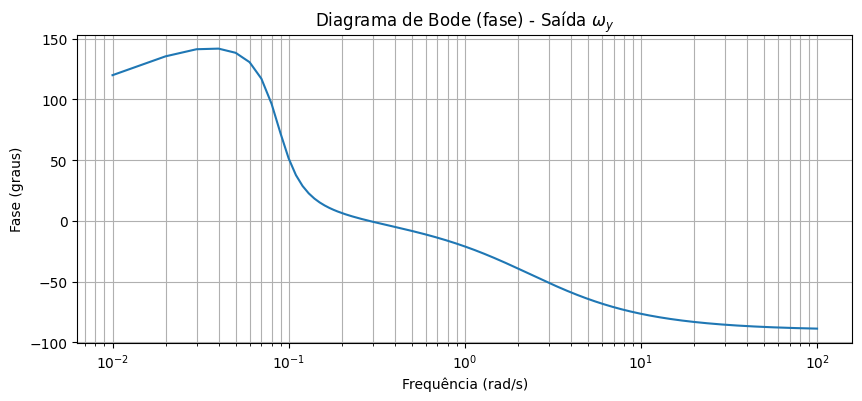

(array([[0.00000000e+00, 3.81818182e+01, 9.98841374e-01, 6.37608576e-03,
        8.13151629e-20]]), array([1.00000000e+00, 2.43993701e+00, 1.42245638e-01, 1.94829206e-02,
       2.01304382e-04]))


In [18]:
C = np.array([0,0,0,1]) # Lembrar de escolher saída (soh funciona sistemas SISO)
D = np.array([0])

# obtenção dos diagramas de Bode a partir do modelo linearizado
sys = scipy.signal.lti(A,B,C,D)
w, mag, phase = scipy.signal.bode(sys, w=np.linspace(1e-2,1e2,10000))

# plot dos diagramas de Bode
plt.figure(1, figsize=(10, 4))
plt.semilogx(w, mag)    # Bode magnitude plot
plt.grid(which='both')
plt.title('Diagrama de Bode (ganho) - Saída ' + r'$\omega_y$')
plt.xlabel('Frequência (rad/s)')
plt.ylabel('Ganho (dB)')
plt.show()

plt.figure(2, figsize=(10, 4))
plt.semilogx(w, phase)    # Bode phase plot
plt.grid(which='both')
plt.title('Diagrama de Bode (fase) - Saída ' + r'$\omega_y$')
plt.xlabel('Frequência (rad/s)')
plt.ylabel('Fase (graus)')
plt.show()

# calculate the transfer function
print(scipy.signal.ss2tf(A,B,C,D))


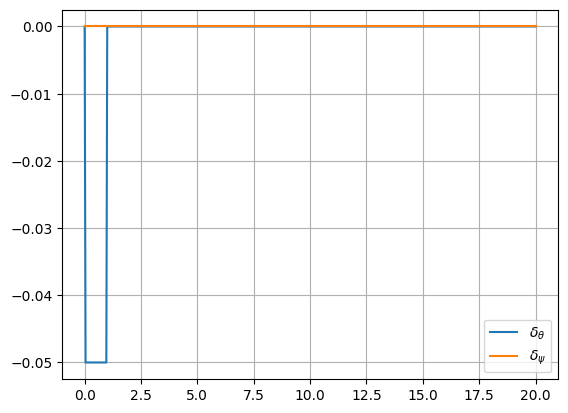

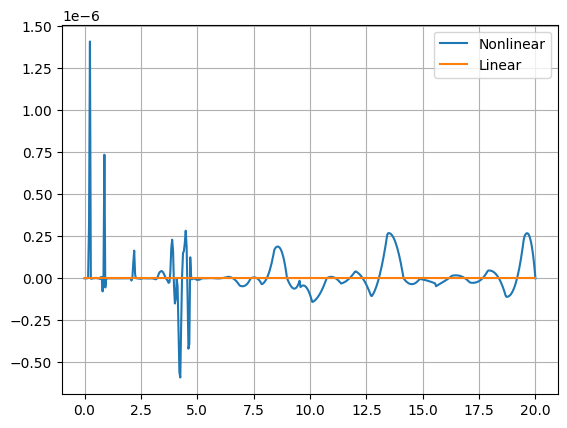

In [21]:
import control as ct

T = 600

def model(t,y,u,params):
    # rotation matrix
    rot = Rotation.from_quat([y[7], y[8], y[9], y[6]])
    rotation_matrix = rot.as_matrix()
    inv_rotation_matrix = np.linalg.inv(rotation_matrix)

    # Euler Angles from quaternions
    u_0 = u[0]
    u_1 = u[1]

    # disturbios
    wind_x = u[2]
    wind_y = u[3]
    wind_z = 0
    wind = np.array([wind_x, wind_y, wind_z])

    # Forces and moments due to propulsion
    thrust_force  = thrust(y[6],y[7],y[8],y[9], u_0, u_1)[0]
    moment_thrust = thrust(y[6],y[7],y[8],y[9], u_0, u_1)[1]

    # Forces and moments due to aerodynamics
    aero_force,aero_moments = aero(y[3],y[4],y[5],y[6],y[7],y[8],y[9],y[10],y[11],y[12],wind)

    gravity_inertial = np.array([0,0,-m*g])
    gravity_body = np.dot(rotation_matrix, gravity_inertial)

    u_dot = (1/m)*(thrust_force + aero_force+ gravity_body) - np.cross(np.array([y[10],y[11],y[12]]), np.array([y[3],y[4],y[5]]))
    #u_dot = np.array([0,0,0])
    r_dot = np.dot(inv_rotation_matrix, np.array([y[3], y[4], y[5]]))

    #transformation_matrix = np.array([[1, np.sin(y[6])*np.tan(y[7]), np.cos(y[6])*np.tan(y[7])], [0, np.cos(y[6]), -np.sin(y[6])], [0, np.sin(y[6])/np.cos(y[7]), np.cos(y[6])/np.cos(y[7])]])
    # quaternion derivative
    # p = y[10]; q = y[11]; r = y[12]
    transformation_matrix = np.array([[0, -y[10], -y[11], -y[12]], [y[10], 0, y[12], -y[11]], [y[11], -y[12], 0, y[10]], [y[12], y[11], -y[10], 0]])
    # euler angle derivatives as a function of angular velocity
    quaternion_dot = 0.5*np.dot(transformation_matrix, np.array([y[6], y[7], y[8], y[9]]))

    # angular acceleration
    J_inv = np.linalg.inv(J)
    omega_dot = np.dot(J_inv, moment_thrust+aero_moments - np.cross(y[10:13], np.dot(J, y[10:13])))

    return np.array([r_dot[0], r_dot[1], r_dot[2], u_dot[0], u_dot[1], u_dot[2], quaternion_dot[0], quaternion_dot[1], quaternion_dot[2], quaternion_dot[3], omega_dot[0], omega_dot[1], omega_dot[2]])

def output(t,y,u,params):
    theta = np.arcsin(2*(y[7]*y[9] - y[6]*y[8]))
    return y[10]

rocket_model = ct.NonlinearIOSystem(model,outfcn=output,inputs=['dtheta','dpsi','wind_x','wind_y'], output='theta')

          # Initial H, L
time_vector = np.linspace(0, 20, 500)   # Simulation 
U = np.zeros((4,500))
d_theta = lambda t: -0.005 if 2 < t < 5 else 0
d_psi = lambda t: 0.000 if 3 < t < 5 else 0

d_theta_array = []
for elem in time_vector:
    if 0 < elem < 1:
        d_theta_array.append(-0.05)
    else:
        d_theta_array.append(0)

U[0,:] = d_theta_array
U[1,:] = np.vectorize(d_psi)(time_vector)

#Definição dos disturbios
dwind = np.zeros((2,500))
for elem in time_vector:
    dwind[0] = wind_x(elem)
    dwind[1] = wind_y(elem)
U[2,:] = dwind[0,:] #disturbio em x
U[3,:] = dwind[1,:] #disturbio em y

# plot U
plt.figure(4)
plt.plot(time_vector, U[0,:])
plt.plot(time_vector, U[1,:])
plt.legend([r'$\delta_\theta$', r'$\delta_\psi$'])
plt.grid()

# Simulate the system
X0 = [0,0,0,10,0,0,0.737, 0.,0.675,0.0,0,0,0]
t, y = ct.input_output_response(rocket_model, time_vector, U, X0, solve_ivp_method='LSODA')
ss = ct.linearize(sys=rocket_model, xeq=[0,0,0,10,0,0,0.737, 0.,0.675,0.0,0,0,0], ueq=[0,0,0,0])
t_linear, y_linear = ct.input_output_response(ss, time_vector, U, X0, solve_ivp_method='LSODA')
#Plot the linear vs nonlinear response
plt.figure(5)
plt.plot(t, y[0,:], label='Nonlinear')
plt.plot(t_linear, y_linear[0,:], label='Linear')
plt.legend()
plt.grid()
plt.show()

# print the state space matrices
#print(ss)
# print the eigenvalues of the A matrix
#print(ss.A)
# plot the eigenvalues
# plt.figure(1)
# plt.plot(np.real(ss.pole()), np.imag(ss.pole()), 'x')
# plt.grid()
# plt.show()


# Plot the results
# plt.figure(5)
# plt.plot(t, y[0, :])
# plt.plot(t, y[1, :])
# plt.plot(t, y[2, :])
# plt.legend([r'$x$', r'$y$', r'$z$'])
# plt.grid()
# plt.show()

# plt.figure(6)
# plt.plot(t, y[3, :])
# plt.plot(t, y[4, :])
# plt.plot(t, y[5, :])
# plt.legend([r'$u$', r'$v$', r'$w$'])
# plt.grid()
# plt.show()

# # plot angle of attack and sideslip
# plt.figure(7)
# alpha = np.arctan2(y[5, :], y[3, :])
# beta = np.arctan2(y[4, :], y[3, :])
# plt.plot(t, alpha*180/np.pi)
# plt.plot(t, beta*180/np.pi)
# plt.legend([r'$\alpha$', r'$\beta$'])
# plt.grid()
# plt.show()


In [22]:
phi = 0
theta = (85/90)*np.pi/2
psi = 0

# calculate quaternions
q0 = np.cos(phi/2)*np.cos(theta/2)*np.cos(psi/2) + np.sin(phi/2)*np.sin(theta/2)*np.sin(psi/2)
q1 = np.sin(phi/2)*np.cos(theta/2)*np.cos(psi/2) - np.cos(phi/2)*np.sin(theta/2)*np.sin(psi/2)
q2 = np.cos(phi/2)*np.sin(theta/2)*np.cos(psi/2) + np.sin(phi/2)*np.cos(theta/2)*np.sin(psi/2)
q3 = np.cos(phi/2)*np.cos(theta/2)*np.sin(psi/2) - np.sin(phi/2)*np.sin(theta/2)*np.cos(psi/2)

# calculate euler angles from quaternions
phi = np.arctan2(2*(q0*q1 + q2*q3), 1 - 2*(q1**2 + q2**2))
theta = np.arcsin(2*(q0*q2 - q3*q1))
psi = np.arctan2(2*(q0*q3 + q1*q2), 1 - 2*(q2**2 + q3**2))

print(phi, theta, psi)

# print quaternions calculated
print(q0, q1, q2, q3)


r = Rotation.from_euler('zyx', [phi, theta, psi], degrees=False)
print(r.as_matrix())
print(r.as_quat())

vector = np.array([1,0,0])
inv_matrix = np.linalg.inv(r.as_matrix())

transformed_vector = np.dot(inv_matrix, vector)
print(transformed_vector)
print(r.as_quat())

0.0 1.4835298641951788 0.0
0.7372773368101241 0.0 0.6755902076156601 0.0
[[ 0.08715574  0.          0.9961947 ]
 [ 0.          1.          0.        ]
 [-0.9961947   0.          0.08715574]]
[0.         0.67559021 0.         0.73727734]
[0.08715574 0.         0.9961947 ]
[0.         0.67559021 0.         0.73727734]


In [23]:
u_vector = lambda t: np.array([0.0003, -0.0007]) if 2 < t < 5 else np.array([0.0, 0.0])
print(u_vector(2))

u0 = lambda t: -0.003 if 3 < t < 6 else 0
u1 = lambda t: 0.003 if 2 < t < 4 else 0
u_vector2 = lambda t: np.array([u0(t), u1(t)])

print(u_vector2(2)[1])

[0. 0.]
0
